# MLP Lesson 2

## Google Cloud Storage Boilerplate

This first cell has some boilerplate to connect the Google Cloud Storage bucket containing the data used for this tutorial to the Google Colab environment. 

In order to access the data for this workshop you'll need to run this cell, follow the link when prompted and copy the Google SDK token into the prompt. If everything works correctly a new folder called `data` should appear in the file browser on the left.

In [1]:
%tensorflow_version 2.x
from google.colab import auth
auth.authenticate_user()

project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!gcloud config set project {project_id}

!mkdir data
!gcsfuse  --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 {bucket_name} /content/data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  17184      0 --:--:-- --:--:-- --:--:-- 17184
OK
58 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 58 not upgraded.
Need to get 4,274 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.28.1_amd64.deb ...
Unpacking gcsfuse (0.28.1) ...
Setting up gcsfuse (0.28.1) ...
Updated property [core/project].
Using mount point: /content/data
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils import resample
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
plt.style.use('ggplot')

## Bigger data - deeper networks

The last exercise gave us an intro into how to build and tune some of the parameters of a neural network. Now we move to an example where we have more data. Generally as we increase the amount of training data we can make use of deeper networks, with more layers to give more accurate predictions.

This time around we load up the data from `ag-muon-data-tight.pkl`

Don't forget to take care of class balance in your dataset.

(array([71387.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 71387.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

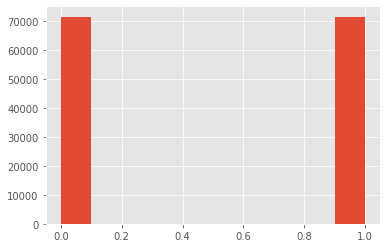

In [3]:
df = pd.read_pickle('/content/data/muon/ag-muon-data-tight.pkl')
X = np.array(df[3].to_list())
y = np.array(df[1].to_list())


num_ag = np.count_nonzero(y==0)
num_no_ag = np.count_nonzero(y==1)

df_majority = df[df[1]==0]
df_minority = df[df[1]==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=num_no_ag,     # to match minority class
                                 random_state=123) # reproducible results

df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_new = df_downsampled.sample(frac=1)

X = np.array(df_new[3].to_list())
y = np.array(df_new[1].to_list())
plt.hist(y)

### Initial network

Try re-running your NN from the previous exercise on this new data. **Note** the input vector now has length 1000, rather than 300. See how the network performs. Use the learning rate that you established in the last study.

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization

model1 = Sequential()
model1.add(Dense(1000, input_dim=1000, activation='relu')) 
model1.add(BatchNormalization())
model1.add(Dense(1000, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(16, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)
model1.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
history = model1.fit(X, y, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
1785/1785 [==============================] - 16s 9ms/step - loss: 0.2448 - accuracy: 0.8845 - val_loss: 3.1471 - val_accuracy: 0.4983
Epoch 2/30
1785/1785 [==============================] - 16s 9ms/step - loss: 0.1032 - accuracy: 0.9611 - val_loss: 5.1882 - val_accuracy: 0.5017
Epoch 3/30
1785/1785 [==============================] - 17s 9ms/step - loss: 0.0864 - accuracy: 0.9680 - val_loss: 0.7361 - val_accuracy: 0.7689
Epoch 4/30
1785/1785 [==============================] - 17s 9ms/step - loss: 0.0766 - accuracy: 0.9716 - val_loss: 0.6989 - val_accuracy: 0.7980
Epoch 5/30
1785/1785 [==============================] - 17s 10ms/step - loss: 0.0709 - accuracy: 0.9741 - val_loss: 0.0588 - val_accuracy: 0.9792
Epoch 6/30
1785/1785 [==============================] - 17s 9ms/step - loss: 0.0649 - accuracy: 0.9767 - val_loss: 2.0247 - val_accuracy: 0.5823
Epoch 7/30
1785/1785 [==============================] - 16s 9ms/step - loss: 0.0606 - accuracy: 0.9784 - val_loss: 0.0713 - val_a

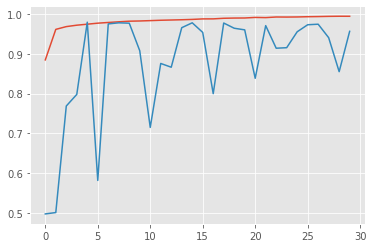

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

### We're going to need a deeper network!

That looks pretty good! However, since we have so much more data now, we might be tempted to use deeper network with more paramters. Try a network with architecture

    INPUT - 1000 - 1000 - 128 - 16 - OUTPUT
    
For this architecture do the same test for learning rate effects, training for 30 epochs at each learning rate.

In [9]:
model2 = Sequential()
model2.add(Dense(1000, input_dim=1000, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(1000, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(16, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=1e-3)
model2.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
history = model2.fit(X, y, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
1785/1785 [==============================] - 16s 9ms/step - loss: 0.2429 - accuracy: 0.8862 - val_loss: 5.3948 - val_accuracy: 0.5017
Epoch 2/30
1785/1785 [==============================] - 16s 9ms/step - loss: 0.1017 - accuracy: 0.9614 - val_loss: 0.8017 - val_accuracy: 0.7222
Epoch 3/30
1785/1785 [==============================] - 17s 10ms/step - loss: 0.0873 - accuracy: 0.9671 - val_loss: 4.9831 - val_accuracy: 0.4983
Epoch 4/30
1785/1785 [==============================] - 17s 10ms/step - loss: 0.0769 - accuracy: 0.9717 - val_loss: 4.2498 - val_accuracy: 0.5072
Epoch 5/30
1785/1785 [==============================] - 17s 9ms/step - loss: 0.0713 - accuracy: 0.9736 - val_loss: 0.2719 - val_accuracy: 0.9076
Epoch 6/30
1785/1785 [==============================] - 17s 9ms/step - loss: 0.0669 - accuracy: 0.9757 - val_loss: 0.0735 - val_accuracy: 0.9738
Epoch 7/30
1785/1785 [==============================] - 16s 9ms/step - loss: 0.0591 - accuracy: 0.9782 - val_loss: 0.0617 - val_

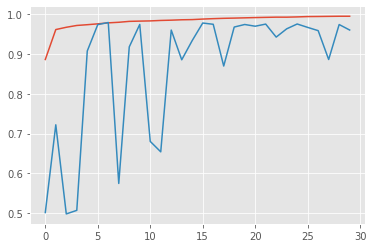

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])